## code flow
- 1. read the csv file containing description
- 2. read the images from images folder using keras generator

## read the csv file with image name and description

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv(r"description/text2img_data_aws.csv",index_col=0)

In [3]:
FEATURE_COLS = [x for x in df.columns if "feature" in x] 

In [4]:
df.loc[df.image_name==df.image_name.iloc[0]][FEATURE_COLS].values.shape

(1, 768)

## images load

In [5]:
import warnings
warnings.simplefilter("ignore")
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image
import joblib
from tqdm.notebook import tqdm

2024-07-16 17:06:03.432675: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-16 17:06:05.183247: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-07-16 17:06:05.183372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-07-16 17:06:05.183381: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make su

In [6]:
version = 1
model_reset = False


project_fold = os.path.join(os.getcwd(),f"version_{version}")
checkpoint_path = os.path.join(project_fold,"checkpoint")
progress_fold = os.path.join(project_fold,"progress")
model_save_path = os.path.join(checkpoint_path,"model")
model_train_details_file = f"model_train_details_{version}"

progress_fold,model_save_path,checkpoint_path,model_train_details_file

('/home/studio-lab-user/text to image/version_1/progress',
 '/home/studio-lab-user/text to image/version_1/checkpoint/model',
 '/home/studio-lab-user/text to image/version_1/checkpoint',
 'model_train_details_1')

In [7]:
def delete_fold_contents(fold_path):
    files = os.listdir(fold_path)
    if len(files)>0:
        for f in files:
            os.remove(os.path.join(fold_path,f))

def delete_fold(fold_path):
    delete_fold_contents(fold_path)
    os.removedirs(fold_path)

In [8]:
tf.random.set_seed(42)
if model_reset:
    model_train_details = {"last_epoch" : 0,"loss":[]}
    joblib.dump(model_train_details,model_train_details_file)
    os.makedirs(progress_fold,exist_ok=True)
    delete_fold_contents(progress_fold)
    os.makedirs(checkpoint_path,exist_ok=True)
    delete_fold_contents(checkpoint_path)

model_train_details = joblib.load(model_train_details_file)    
INIT_EPOCH = model_train_details.get("last_epoch")    
loss_arr = model_train_details.get("loss")

In [9]:
image = Image.open("images/0b52eb15-dc23-48a8-82a1-f983bf46af2f.png")

In [10]:
np.array(image).shape

(256, 256, 3)

In [11]:
IMG_FOLD = os.path.join("images")
BATCH_SIZE = 8
IMG_SHAPE = (64,64,3)
LEARNING_RATE = 2e-4

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    IMG_FOLD, 
    label_mode=None, 
    image_size=(IMG_SHAPE[0], IMG_SHAPE[1]), 
    batch_size=BATCH_SIZE,
    shuffle=False
)

file_paths = dataset.file_paths

Found 956 files belonging to 1 classes.


In [12]:
def show_sample_imgs(imgs):
    
    plt.figure(figsize=(8, 8))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.imshow(imgs[i])
        plt.axis('off')

batch info : (8, 64, 64, 3)
----------------------------------


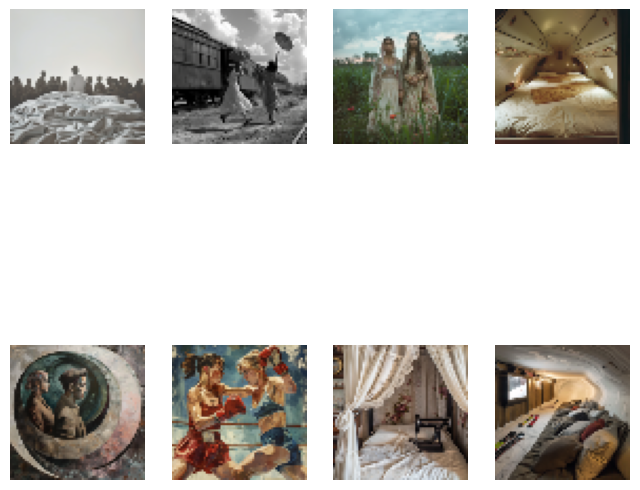

In [13]:
for i in dataset.take(1):
    print("batch info :", i.shape)
    print("----------------------------------")
show_sample_imgs(i/255)

In [14]:
IMG_SIZE = IMG_SHAPE[0]
TIMESTEPS = 4
time_bar = 1 - np.linspace(0, 1.0, TIMESTEPS + 1)
time_bar

array([1.  , 0.75, 0.5 , 0.25, 0.  ])

In [15]:
def forward_noise(x, t):
    # time_bar[t] gives amount of noise to be included at time t and t+1 
    a = tf.reshape(time_bar[t], (-1, 1, 1, 1))
    b = tf.reshape(time_bar[t + 1], (-1, 1, 1, 1))
    noise = tf.cast(tf.random.normal(shape=tf.shape(x)), tf.float32)
    img_a = x * (1.0 - tf.cast(a, tf.float32)) + noise * tf.cast(a, tf.float32)
    img_b = x * (1.0 - tf.cast(b, tf.float32)) + noise * tf.cast(b, tf.float32)
    return img_a, img_b
    
def generate_ts(batch_size,timesteps):
    return np.random.randint(0, timesteps, size=batch_size)

In [16]:
def block(img,time,text):
    
    img_feats = layers.Conv2D(128, kernel_size=3, padding='same')(img)
    img_feats = layers.Activation('relu')(img_feats)
    
    time_feats = layers.Dense(128)(time)
    time_feats = layers.Activation('relu')(time_feats)
    time_feats = layers.Reshape((1, 1, 128))(time_feats)
    
    text_feats = layers.Dense(128)(text)
    text_feats = layers.Activation('relu')(text_feats)
    text_feats = layers.Reshape((1, 1, 128))(text_feats)
    
    
    feats = img_feats * time_feats * text_feats
    
    img_time_feats = layers.Conv2D(128, kernel_size=3, padding='same')(feats)
    img_time_text_feats = img_time_feats + time_feats + text_feats
    img_time_text_feats = layers.LayerNormalization()(img_time_text_feats)
    img_time_text_feats = layers.Activation('relu')(img_time_text_feats)
    
    return img_time_text_feats

In [17]:
def build_model():
    
    IMG_SIZE_SMALLEST = int(IMG_SIZE/8)
    
    x = img_input = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='image_input')
    x_ts = x_ts_input = layers.Input(shape=(1,), name='timestamp_input')
    
    x_text = x_text_input = layers.Input(shape=(768,), name='text_input')
    
    x_text = layers.Dense(128)(x_text)
    x_text = layers.LayerNormalization()(x_text)
    x_text = layers.Activation('relu')(x_text)
    
    x_ts = layers.Dense(128)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)
    
    x = x_vl = block(x, x_ts, x_text) # 256
    x = layers.MaxPool2D(2)(x)
    x = x_l = block(x, x_ts,x_text) # 128
    x = layers.MaxPool2D(2)(x)
    x = x_m = block(x, x_ts,x_text) # 64
    x = layers.MaxPool2D(2)(x)
    x = x_s = block(x, x_ts,x_text) # 32
    
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dense(IMG_SIZE_SMALLEST * IMG_SIZE_SMALLEST * 128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((IMG_SIZE_SMALLEST, IMG_SIZE_SMALLEST, 128))(x)
    
    x = layers.Concatenate()([x, x_s])
    x = block(x, x_ts,x_text)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x_m])
    x = block(x, x_ts,x_text)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x_l])
    x = block(x, x_ts,x_text)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x_vl])
    x = block(x, x_ts,x_text)           
    x = layers.Conv2D(3, kernel_size=1, padding='same')(x)
    model = tf.keras.models.Model([img_input, x_ts_input,x_text_input], x) 
    
    return model

In [18]:
def custom_mse_loss(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    return mse_loss

In [19]:
model = build_model()
model_opt = tf.keras.optimizers.Adam(0.0008)
model.compile(optimizer=model_opt,loss=custom_mse_loss)
init_wts = model.get_weights()[0].sum()
checkpoint = tf.train.Checkpoint(model=model, optimizer=model_opt)

if os.path.exists(checkpoint_path):
    checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))
    loaded_wts = model.get_weights()[0].sum()
    if init_wts!=loaded_wts:
        print("Checkpoint found! Trying to resume training from last checkpoint")
        print("Model weigths from last checkpoint loaded successfully")


Checkpoint found! Trying to resume training from last checkpoint
Model weigths from last checkpoint loaded successfully


In [20]:
@tf.function
def train_step(img_batch,text_inputs):

    noise = tf.random.normal(shape=tf.shape(img_batch), dtype=tf.float32)
    for t in range(0,TIMESTEPS):

        noise_fact_prev = tf.reshape(time_bar[t], (-1, 1,1, 1))
        noise_fact_curr = tf.reshape(time_bar[t + 1], (-1,1, 1, 1))
        img_prev = img_batch * (1.0 - tf.cast(noise_fact_prev, tf.float32)) + noise * tf.cast(noise_fact_prev, tf.float32)
        img_curr = img_batch * (1.0 - tf.cast(noise_fact_curr, tf.float32)) + noise * tf.cast(noise_fact_curr, tf.float32)
        batch_size = img_batch.shape[0]
        img_ts = tf.random.uniform([batch_size],minval=t,maxval=t+1,dtype=tf.int32)
        
        with tf.GradientTape() as tape:
            predictions = model([img_prev,img_ts,text_inputs], training=True)
            loss_value = custom_mse_loss(img_curr, predictions)
    
        gradients = tape.gradient(loss_value, model.trainable_weights)
        model_opt.apply_gradients(zip(gradients, model.trainable_weights))

    return loss_value

In [21]:
def get_text_feats_img_name(df,img_name_ls):
    
    text_embs = []
    
    for img_name in img_name_ls:
        text_embs_i = df.loc[df.image_name==img_name][FEATURE_COLS].values[0]
        text_embs.append(text_embs_i)
    
    return tf.convert_to_tensor(text_embs)


def scale_images(image):
    image = tf.cast(image, tf.float32)
    image /= 255.0
    return image

In [22]:
EPOCHS = 200

In [23]:
for epoch in tqdm(range(INIT_EPOCH, INIT_EPOCH + EPOCHS)):
    for idx,data in enumerate(dataset):
        
        file_paths_batch = file_paths[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
        file_paths_batch = [x.replace("images/","") for x in file_paths_batch]
        text_inputs = get_text_feats_img_name(df=df,img_name_ls=file_paths_batch)
        
        train_dataset = data/255
        
        loss = train_step(img_batch=train_dataset,text_inputs=text_inputs)

    loss_arr.append(loss.numpy())
    print(f"epoch {epoch+1} > loss {loss}")
    print("===========================")

  0%|          | 0/200 [00:00<?, ?it/s]

epoch 2201 > loss 0.0019559385254979134
epoch 2202 > loss 0.0018639584304764867
epoch 2203 > loss 0.002002825727686286
epoch 2204 > loss 0.0018834536895155907
epoch 2205 > loss 0.0018758457154035568
epoch 2206 > loss 0.0018307855352759361
epoch 2207 > loss 0.0018490091897547245
epoch 2208 > loss 0.001820220029912889
epoch 2209 > loss 0.001983528956770897
epoch 2210 > loss 0.0019327931804582477
epoch 2211 > loss 0.001958871725946665
epoch 2212 > loss 0.0018603651551529765
epoch 2213 > loss 0.0018496023258194327
epoch 2214 > loss 0.001805456937290728
epoch 2215 > loss 0.0018056562403216958
epoch 2216 > loss 0.0018702134257182479
epoch 2217 > loss 0.0018788542365655303
epoch 2218 > loss 0.0018768986919894814
epoch 2219 > loss 0.001809340319596231
epoch 2220 > loss 0.0018066769698634744
epoch 2221 > loss 0.0019082481740042567
epoch 2222 > loss 0.001957159722223878
epoch 2223 > loss 0.0018322375835850835
epoch 2224 > loss 0.0018887388287112117
epoch 2225 > loss 0.0018828511238098145
epoch 2

In [24]:
checkpoint.save(model_save_path)
model_train_details = {"last_epoch" : epoch+1,"loss":loss_arr}
joblib.dump(model_train_details,model_train_details_file)

['model_train_details_1']

['A living area with sofa, ottoman and a sink a tiled floor']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


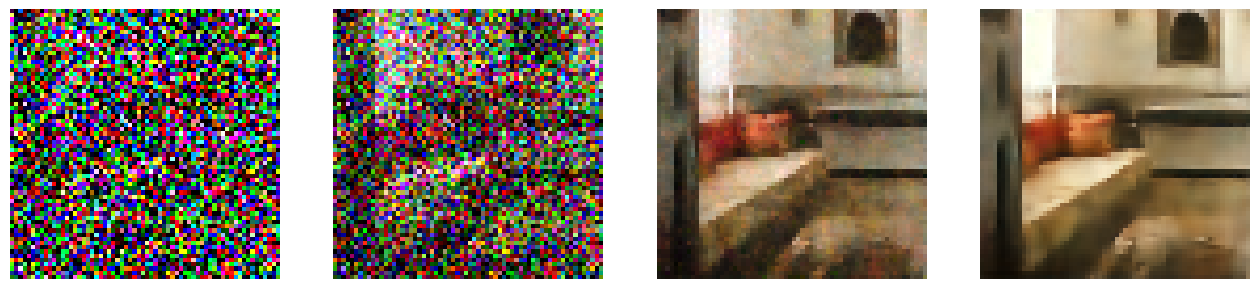

In [25]:
img = tf.cast(tf.random.normal(shape=(1,IMG_SIZE,IMG_SIZE,3)), tf.float32)

data = df.sample(1)
txt = data["text"].values.tolist()
print(txt)
txt_emb = tf.convert_to_tensor(data[FEATURE_COLS].values.tolist())
#txt_emb = tf.convert_to_tensor(df[FEATURE_COLS].sample(1).values.tolist())
img_res_ls = []

for m in range(TIMESTEPS):
    img = model.predict([img,tf.random.uniform([1],minval=m,maxval=m+1),txt_emb],verbose=0)
    img_res_ls.append(img)
    
plt.figure(figsize=(16,4))
for k in range(1,TIMESTEPS+1):
    plt.subplot(1,TIMESTEPS,k)
    plt.imshow(img_res_ls[k-1][0])
    plt.axis("off");

prog_img_save_path = os.path.join(progress_fold,f'image_epoch_{model_train_details.get("last_epoch")}.png')
plt.savefig(prog_img_save_path)    

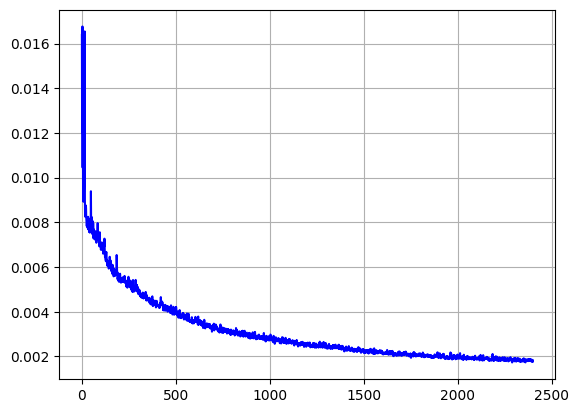

In [26]:
plt.plot(model_train_details.get("loss"),color="blue")
plt.grid(True);